## Libraries

In [1]:
!pip install --user kaggle
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/"
!kaggle competitions download -c titanic
%pip install -q tensorflow-recommenders
import tensorflow_recommenders as tfrs
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
from tensorflow import keras
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
SEED=2021

  0% 0.00/59.8k [00:00<?, ?B/s]
100% 59.8k/59.8k [00:00<00:00, 56.8MB/s]
  0% 0.00/28.0k [00:00<?, ?B/s]
100% 28.0k/28.0k [00:00<00:00, 50.5MB/s]
  0% 0.00/3.18k [00:00<?, ?B/s]
100% 3.18k/3.18k [00:00<00:00, 3.38MB/s]
     |████████████████████████████████| 85 kB 4.1 MB/s 


## Helpers

### General helpers

In [2]:
def sample(df):
  df = df.sample(frac=1, random_state=SEED)
  df = df.reset_index(drop=True)
  return df
def normalize_df(df):
  columns = df.columns
  for c in columns:
    df[c] = (df[c] - np.min(df[c])) / (np.max(df[c]) - np.min(df[c]))
  return df
def _split_train_valid_(X, y, frac):
  n = int(len(X)*frac)
  train_X, train_y = X[0:n], y[0:n] 
  valid_X, valid_y = X[n:], y[n:]
  return (train_X, train_y, valid_X, valid_y)
def split_train_valid(df, y_column, X_columns=None, frac=0.85):
  if X_columns:
    X = df[X_columns].to_numpy()
  else:
    X = df.drop(columns=[y_column]).to_numpy()
  y = df[y_column].to_numpy()
  return _split_train_valid_(X, y, frac)
def series_map(series, f):
  return series.apply(f)

### Model related helpers

In [86]:
class vocab_lookup_layer(keras.layers.Layer):
    # https://stackoverflow.com/questions/58507400/how-to-use-tf-lookup-tables-with-tensorflow-2-0-keras-and-mlflow
    def __init__(self, vocab, num_oov_buckets, **kwargs):
      self.vocab = vocab
      self.num_oov_buckets = num_oov_buckets
      super(vocab_lookup_layer, self).__init__(**kwargs)
    def build(self, input_shape):
      vocab_initializer = tf.lookup.KeyValueTensorInitializer(
        self.vocab, tf.range(len(self.vocab), dtype=tf.int64)
      )
      self.table = tf.lookup.StaticVocabularyTable(vocab_initializer, self.num_oov_buckets)
      self.built = True
    def call(self, inputs):
      return self.table.lookup(inputs)
    def get_config(self):
      return {'vocab': self.vocab, 'num_oov_buckets': self.num_oov_buckets}
def embedding_layer(vocab, output_dim=4, num_oov_buckets=100, dtype=tf.int64):
    table = vocab_lookup_layer(vocab, num_oov_buckets)
    categorical_feature_input = keras.layers.Input(shape=[], dtype=dtype)
    indexes = keras.layers.Lambda(lambda c: table(c))(categorical_feature_input)
    embeddings = keras.layers.Embedding(input_dim=len(vocab)+num_oov_buckets, output_dim=output_dim)(indexes)
    return categorical_feature_input, embeddings
def train_model(model, X, y, valid_X, valid_y, loss, 
                callbacks_flag=True, 
                epochs=100000,
                metrics=[tf.keras.metrics.PrecisionAtRecall(0.85), 
                         keras.metrics.binary_accuracy],
                monitor="val_binary_accuracy", 
                class_weight={},
                lr=1e-3,
                patience=20, 
                decay_rate=0.1):
  if callbacks_flag:
    callbacks = [
      keras.callbacks.EarlyStopping(
        patience=patience, 
        restore_best_weights=True, 
        monitor=monitor
      )
    ]
  else:
    callbacks = []
  lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=lr,
    decay_steps=500,
    decay_rate=decay_rate)
  optimizer=keras.optimizers.Adam(learning_rate=lr_schedule)
  model.compile(
      optimizer=optimizer, 
      loss=loss,
      metrics=metrics
  )
  hist = model.fit(
      x=X, 
      y=y, 
      validation_data=(valid_X, valid_y), 
      epochs=epochs,
      callbacks=callbacks,
      class_weight=class_weight
  ) 
  return hist
def dense_layer(n_units, previous_output, BN=True, DR=False,
                KR=None, name=None, activation=keras.activations.relu,
                KI='he_normal'):
    layer = keras.layers.Dense(
        n_units, 
        activation=activation, 
        kernel_initializer=KI,
        kernel_regularizer=KR
    )
    output = layer(previous_output)
    if name:
        layer._name=name
    if DR:
        output = keras.layers.Dropout(DR)(output)
    if BN:
        output = keras.layers.BatchNormalization()(output)
    return output
def get_the_best_epochs_num(
    hist, 
    best_epoch_metric="val_binary_accuracy", 
    metrics=["val_precision_at_recall", "val_binary_accuracy"]
):
  n_epochs_best = np.argmax(hist.history[best_epoch_metric])
  results = [n_epochs_best+1, hist.history["val_loss"][n_epochs_best]]
  for metric in metrics:
    results.append(hist.history[metric][n_epochs_best])
  return results
def get_model_without_top(model):
  model_reduced = keras.Sequential()
  for layer in model.layers[:-1]:
    model_reduced.add(layer)
  return model_reduced

### Titanic helpers

In [4]:
def save_submission(predictions):
  to_1_or_0 = (predictions >= 0.5)
  to_int = np.array(to_1_or_0, dtype=int)
  survivied_predictions = to_int.flatten()
  submission = pd.DataFrame(data={"PassengerId":PassengerId,
  "Survived":survivied_predictions})
  submission.to_csv("submission_df", index=False)
def get_df_numpy(df):
  if type(df) == tuple:
    df_numpy = df
  else:
    df_numpy = df.to_numpy()
  return df_numpy
def submit(df, model):
  predictions = model.predict(get_df_numpy(df))
  save_submission(predictions)
def ensemble_submit(models):
  flag = False
  evaluation_results = []
  for model, df, evaluation_result in models:
    if not flag:
      predictions = np.ndarray.flatten(model.predict(get_df_numpy(df)))*evaluation_result
      flag = True
    else:
      predictions = np.add(predictions, np.ndarray.flatten(model.predict(get_df_numpy(df)))*evaluation_result)
    evaluation_results.append(evaluation_result)
  predictions = predictions/np.sum(evaluation_results)
  save_submission(predictions)
  return predictions

## Data

### Original dataset

In [5]:
titanic_train = pd.read_csv("/content/train.csv")
titanic_test = pd.read_csv("/content/test.csv")
PassengerId = titanic_test.PassengerId

###Data Exploration

In [ ]:
titanic_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


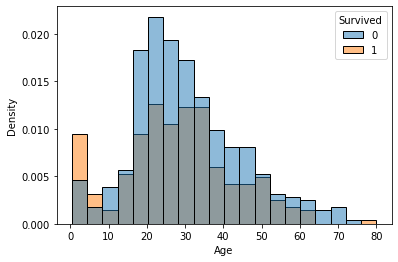

In [ ]:
sns.histplot(data=titanic_train, x="Age", hue="Survived", stat="density")

### data preprocess

In [6]:
def base_preprocess(df):
  df = df.drop(columns=["PassengerId", "Name", "Ticket", "Cabin"])
  df = df.dropna(subset=["Embarked"])
  df["Sex"] = df.Sex.map({"male":1, "female":0})
  df["Embarked"] = df.Embarked.map({"S":0, "C":1, "Q":2})
  return df
def base_preprocess_2(df):
  df = df.drop(columns=["PassengerId", "Ticket", "Cabin"])
  df = df.dropna(subset=["Embarked"])
  df["Sex"] = df.Sex.map({"male":1, "female":0})
  df["Embarked"] = df.Embarked.map({"S":0, "C":1, "Q":2})
  return df
def cut_age(df):
  bins = pd.IntervalIndex.from_tuples([(0, 10), (10, 70), (70, 1000)])
  df["Age"] = pd.cut(df.Age, bins=bins).cat.codes.astype(int)
  return df
def cut_sibsp(df):
  bins = pd.IntervalIndex.from_tuples([(-1, 0), (0, 10000)])
  df["SibSp"] = pd.cut(df.SibSp, bins=bins).cat.codes.astype(int)
  return df
def cut_parch(df):
  bins = pd.IntervalIndex.from_tuples([(-1, 0), (0, 10000)])
  df["Parch"] = pd.cut(df.Parch, bins=bins).cat.codes.astype(int)
  return df
def cut_fare(df):
  bins = pd.IntervalIndex.from_tuples([(-1, 8), (8, 15), (15, 31), (31, 10000)])
  df["Fare"] = pd.cut(df.Fare, bins=bins).cat.codes.astype(int)
  return df
def hot_encoding(df, age=True):
  if age:
    data = [
      df,
      pd.get_dummies(df['Embarked'], prefix='Embarked', dtype=np.int8),
      pd.get_dummies(df['Sex'], prefix='Sex', dtype=np.int8),
      pd.get_dummies(df['Pclass'], prefix='Pclass', dtype=np.int8),
      pd.get_dummies(df['Age'], prefix='Pclass', dtype=np.int8),
      pd.get_dummies(df['SibSp'], prefix='SibSp', dtype=np.int8),
      pd.get_dummies(df['Parch'], prefix='Parch', dtype=np.int8),
      pd.get_dummies(df['Fare'], prefix='Fare', dtype=np.int8)        
    ]
    columns=["Pclass", "Sex", "Embarked", "Age", "SibSp", "Parch", "Fare"]
  else:
    data = [
      df,
      pd.get_dummies(df['Embarked'], prefix='Embarked', dtype=np.int8),
      pd.get_dummies(df['Sex'], prefix='Sex', dtype=np.int8),
      pd.get_dummies(df['Pclass'], prefix='Pclass', dtype=np.int8),
      pd.get_dummies(df['SibSp'], prefix='SibSp', dtype=np.int8),
      pd.get_dummies(df['Parch'], prefix='Parch', dtype=np.int8),
      pd.get_dummies(df['Fare'], prefix='Fare', dtype=np.int8)        
    ]
    columns=["Pclass", "Sex", "Embarked", "SibSp", "Parch", "Fare", "Survived"]
  df = pd.concat(
      data,
      axis=1
  )
  return df.drop(columns=columns)
def preprocess(df, test=False, base_preprocess=base_preprocess):
  df = base_preprocess(df)
  # test data have missing values in age and fare 
  if test:
    df["Age"] = df.Age.fillna(1) #1 is the mode of Age in training dataset
    df["Fare"] = df.Fare.fillna(0) #0 is the mode of Fare in training dataset
  else: 
    df = sample(df)
  df = cut_age(df)
  df = cut_sibsp(df)
  df = cut_parch(df)
  df = cut_fare(df)
  return df
def age_preprocess(df, predict=False):
  if not predict:
    df = df[df.Age != -1]
  df = hot_encoding(df, age=False)
  return df
def preprocess1(df):
  df = df[df.Age != -1]
  df = hot_encoding(df)
  df = normalize_df(df)
  return df
def age_to_mode(x):
  if x==-1: return 1
  else: return x
def preprocess2(df):
  df = df.copy()
  df["Age"] = series_map(df.Age, age_to_mode)
  df = hot_encoding(df)
  df = normalize_df(df)
  return df
def preprocess3(df):
  df = df.copy()
  df["Age"] = predicted_ages
  df = hot_encoding(df)
  df = normalize_df(df)
  return df
def only_remain_name_title(x):
  return str(x.split()[1])
def preprocess4(df):
  df = df.copy()
  df = df[df.Age != -1]
  df["Name"] = series_map(df.Name, only_remain_name_title)
  for column in df.columns:
    if column != "Name":
      df[column] = df[column].astype(np.int64)
  return df

### data preparation zone

In [7]:
train_base = preprocess(titanic_train)
test_base = preprocess(titanic_test, test=True)

train_base_2 = preprocess(titanic_train, base_preprocess=base_preprocess_2)
test_base_2 = preprocess(titanic_test, test=True, base_preprocess=base_preprocess_2)

#### delete NA age

In [8]:
full_train_1 = preprocess1(train_base)
full_test_1 = preprocess1(test_base)
train_X_1, train_y_1, valid_X_1, valid_y_1 = split_train_valid(full_train_1, "Survived", X_columns=None, frac=0.85)
full_train_X_1, full_train_y_1, _, _ = split_train_valid(full_train_1, "Survived", X_columns=None, frac=1)

NA age replaced by mode of Age

In [9]:
full_train_2 = preprocess2(train_base)
full_test_2 = preprocess2(test_base)
train_X_2, train_y_2, valid_X_2, valid_y_2 = split_train_valid(full_train_2, "Survived", X_columns=None, frac=0.85)
full_train_X_2, full_train_y_2, _, _ = split_train_valid(full_train_2, "Survived", X_columns=None, frac=1)

NA age replaced by predicted values

In [15]:
full_train_3 = preprocess3(train_base)
full_test_3 = preprocess3(test_base)
train_X_3, train_y_3, valid_X_3, valid_y_3 = split_train_valid(full_train_3, "Survived", X_columns=None, frac=0.85)
full_train_X_3, full_train_y_3, _, _ = split_train_valid(full_train_3, "Survived", X_columns=None, frac=1)

Use Embedding

In [10]:
full_train_4 = preprocess4(train_base_2)
full_test_4 = preprocess4(test_base_2)
train_X_4, train_y_4, valid_X_4, valid_y_4 = split_train_valid(full_train_4, "Survived", X_columns=None, frac=0.85)
full_train_X_4, full_train_y_4, _, _ = split_train_valid(full_train_4, "Survived", X_columns=None, frac=1)
train_X_4_tuple, valid_X_4_tuple, full_test_4_tuple = tuple(), tuple(), tuple()
_full_test_4_ = full_test_4.to_numpy()
for i in range(8):
  try:
    train_X_4_tuple += (tf.constant(train_X_4[:, i], dtype=tf.int64), )
    valid_X_4_tuple += (tf.constant(valid_X_4[:, i], dtype=tf.int64), )
    full_test_4_tuple += (tf.constant(_full_test_4_[:, i], dtype=tf.int64), )
  except:
    train_X_4_tuple += (tf.constant(train_X_4[:, i], dtype=tf.string), )
    valid_X_4_tuple += (tf.constant(valid_X_4[:, i], dtype=tf.string), )
    full_test_4_tuple += (tf.constant(_full_test_4_[:, i], dtype=tf.string), )

## Algortithms

### models

In [11]:
def deep_model(input_num, neurons):
  keras.backend.clear_session()
  np.random.seed(SEED)
  tf.random.set_seed(SEED)
  initial_inputs = keras.layers.Input(shape=input_num)
  inputs = initial_inputs
  for neuron in neurons:
    inputs = dense_layer(neuron, inputs)
  output = keras.layers.Dense(1, activation="sigmoid")(inputs)
  model = keras.models.Model(
    inputs=initial_inputs,
    outputs=output
  )
  return model

def resnet_model(input_num, neurons):
  # keep neurons number all same
  keras.backend.clear_session()
  np.random.seed(SEED)
  tf.random.set_seed(SEED)
  initial_inputs = keras.layers.Input(shape=input_num)
  inputs = dense_layer(neurons[0], initial_inputs)
  for neuron in neurons[1:]:
    inputs += dense_layer(neuron, inputs)
    inputs = keras.layers.BatchNormalization()(inputs)
  output = keras.layers.Dense(1, activation="sigmoid")(inputs)
  model = keras.models.Model(
    inputs=initial_inputs,
    outputs=output
  )
  return model

def densenet_model(input_num, neurons):
  # keep neurons number all same
  keras.backend.clear_session()
  np.random.seed(SEED)
  tf.random.set_seed(SEED)
  initial_inputs = keras.layers.Input(shape=input_num) 
  concat_inputs = initial_inputs
  for neuron in neurons:
    prev_inputs = dense_layer(neuron, concat_inputs)
    concat_inputs = keras.layers.concatenate(
        [
            prev_inputs,
            concat_inputs
        ]
    )
  output = keras.layers.Dense(1, activation="sigmoid")(concat_inputs)
  model = keras.models.Model(
    inputs=initial_inputs,
    outputs=output
  )
  return model

def resnet_and_wide_model(input_num, neurons):
  # keep neurons number all same
  keras.backend.clear_session()
  np.random.seed(SEED)
  tf.random.set_seed(SEED)
  initial_inputs = keras.layers.Input(shape=input_num)
  inputs = dense_layer(neurons[0], initial_inputs)
  for neuron in neurons[1:]:
    inputs += dense_layer(neuron, inputs)
    inputs = keras.layers.BatchNormalization()(inputs)
  final_inputs = keras.layers.concatenate(
      [
          inputs,
          initial_inputs
      ]
  )
  output = keras.layers.Dense(1, activation="sigmoid")(final_inputs)
  model = keras.models.Model(
    inputs=initial_inputs,
    outputs=output
  )
  return model

def deep_and_wide_model(input_num, neurons):
  keras.backend.clear_session()
  np.random.seed(SEED)
  tf.random.set_seed(SEED)
  initial_inputs = keras.layers.Input(shape=input_num)
  inputs = initial_inputs
  for neuron in neurons:
    inputs = dense_layer(neuron, inputs)
  final_inputs = keras.layers.concatenate(
      [
          inputs,
          initial_inputs
      ]
  )
  output = keras.layers.Dense(1, activation="sigmoid")(final_inputs)
  model = keras.models.Model(
    inputs=initial_inputs,
    outputs=output
  )
  return model


def dcn_model(input_num, nerous):
    keras.backend.clear_session()
    np.random.seed(SEED)
    tf.random.set_seed(SEED)
    inputs = keras.layers.Input(shape=input_num)
    c1 = tfrs.layers.dcn.Cross()(inputs, inputs)
    c2 = tfrs.layers.dcn.Cross()(inputs, c1)
    c3 = tfrs.layers.dcn.Cross()(inputs, c2)
    c4 = tfrs.layers.dcn.Cross()(inputs, c3)
    c5 = tfrs.layers.dcn.Cross()(inputs, c4)
    c6 = tfrs.layers.dcn.Cross()(inputs, c5)
    final_inputs = keras.layers.concatenate(
        [
            inputs,
            c6
        ]
    )
    for neuron in neurons:
      final_inputs = dense_layer(neuron, final_inputs)
    output = keras.layers.Dense(1, activation="sigmoid")(final_inputs)
    model = keras.models.Model(
      inputs=inputs,
      outputs=output
    )
    return model

def age_deep_model(input_num, neurons):
  keras.backend.clear_session()
  np.random.seed(SEED)
  tf.random.set_seed(SEED)
  initial_inputs = keras.layers.Input(shape=input_num)
  inputs = initial_inputs
  for neuron in neurons:
    inputs = dense_layer(neuron, inputs)
  output = keras.layers.Dense(3, activation="softmax")(inputs)
  model = keras.models.Model(
    inputs=initial_inputs,
    outputs=output
  )
  return model

Pclass_vocab = train_base_2["Pclass"].unique()
Name_vocab = train_base_2["Name"].unique()
Sex_vocab = train_base_2["Sex"].unique()
Age_vocab = train_base_2["Age"].unique()
SibSp_vocab = train_base_2["SibSp"].unique()
Parch_vocab = train_base_2["Parch"].unique()
Fare_vocab = train_base_2["Fare"].unique()
Embarked_vocab = train_base_2["Embarked"].unique()
def deep_embedding_layer(neurons):
  keras.backend.clear_session()
  np.random.seed(SEED)
  tf.random.set_seed(SEED)
  pclass_input, pclass_embedding = embedding_layer(Pclass_vocab)
  name_input, name_embedding = embedding_layer(Name_vocab, dtype=tf.string)
  sex_input, sex_embedding = embedding_layer(Sex_vocab)
  age_input, age_embedding = embedding_layer(Age_vocab)
  sibsp_input, sibsp_embedding = embedding_layer(SibSp_vocab)
  parch_input, parch_embedding = embedding_layer(Parch_vocab)
  fare_input, fare_embedding = embedding_layer(Fare_vocab)
  embarked_input, embarked_embedding = embedding_layer(Embarked_vocab)
  inputs = keras.layers.concatenate(
        [
            pclass_embedding, 
            name_embedding, 
            sex_embedding, 
            age_embedding, 
            sibsp_embedding,
            parch_embedding,
            fare_embedding,
            embarked_embedding
        ]
    )
  for neuron in neurons:
    inputs = dense_layer(neuron, inputs)
  output = keras.layers.Dense(1, activation="sigmoid")(inputs)
  embedding_inputs=[
    pclass_input, 
    name_input, 
    sex_input, 
    age_input, 
    sibsp_input,
    parch_input,
    fare_input,
    embarked_input
  ]
  model = keras.models.Model(
    inputs=embedding_inputs,
    outputs=output,
  )
  return model

### loss function

In [12]:
binary_crossentropy = keras.losses.binary_crossentropy

def dice_similarity_loss(y_true, y_pred):
  dice_similarity = (2.0*tf.math.reduce_sum(y_true*y_pred)) / (tf.math.reduce_sum(y_true*y_true) + tf.math.reduce_sum(y_pred*y_pred))
  return 1 - dice_similarity

negative = sum(titanic_train.Survived==0)
positive = sum(titanic_train.Survived==1)
total = len(titanic_train)
negative_weight = (1 / negative) * (total / 2.0)
positive_weight = (1 / positive) * (total / 2.0)
weight = {0: negative_weight, 1: positive_weight}
print(weight)
def weighted_loss(y_true, y_pred):
  positive_true = y_true
  negative_true = 1 - y_true
  positive_pred = positive_true * y_pred
  negative_pred = 1 - negative_true * y_pred
  p = binary_crossentropy(positive_true, positive_pred)*positive_weight
  n = binary_crossentropy(negative_true, negative_pred)*negative_weight
  return p + n

{0: 0.8114754098360656, 1: 1.3026315789473684}


### Train Age Prediction Models

In [14]:
# age_full_train = age_preprocess(train_base)
# age_full_train_predict = age_preprocess(train_base, predict=True)

# age_train_X, age_train_y, age_valid_X, age_valid_y = split_train_valid(age_full_train, "Age", X_columns=None, frac=0.85)

# def age_by_model(x):
#   if x.Age==-1:
#     predictors = x[age_full_train.drop(columns="Age").columns]
#     predictors_to_np = np.array([predictors])
#     predicted_ages = age_model.predict(predictors_to_np)
#     return np.argmax(predicted_ages[0])
#   return x.Age

# def get_predicted_age(df):
#   df = df.copy()
#   return df.apply(age_by_model, axis=1)

# neurons = [64, 64]
# age_model = age_deep_model(len(age_train_X[0]), neurons) # (13, 0.4490162432193756, 0.7678571343421936, 0.8317757248878479)
# hist = train_model(
#     age_model, age_train_X, age_train_y, age_valid_X, age_valid_y, 
#     keras.losses.sparse_categorical_crossentropy,
#     metrics=[],
#     monitor="val_loss", class_weight={0: 10, 1: 0.55, 2: 0.55})
# predicted_ages = get_predicted_age(age_full_train_predict)

### Train Survived Prediction Models

In [21]:
# neurons = [64, 64]
# deep_model_based_on_preprocess1_bc = deep_model(len(train_X_1[0]), neurons) 
# hist = train_model(deep_model_based_on_preprocess1_bc, train_X_1, train_y_1, valid_X_1, valid_y_1, binary_crossentropy)

# neurons = [64, 64]
# deep_model_based_on_preprocess1_dsl = deep_model(len(train_X_1[0]), neurons) 
# hist = train_model(deep_model_based_on_preprocess1_dsl, train_X_1, train_y_1, valid_X_1, valid_y_1, dice_similarity_loss)

# neurons = [64, 64]
# deep_model_based_on_preprocess1_wbc = deep_model(len(train_X_1[0]), neurons)
# hist = train_model(deep_model_based_on_preprocess1_wbc, train_X_1, train_y_1, valid_X_1, valid_y_1, weighted_loss)

# neurons = [64, 64]
# deep_and_wide_model_based_on_preprocess1_bc = deep_and_wide_model(len(train_X_1[0]), neurons) 
# hist = train_model(deep_and_wide_model_based_on_preprocess1_bc, train_X_1, train_y_1, valid_X_1, valid_y_1, binary_crossentropy)

# neurons = [64, 64]
# deep_and_wide_model_based_on_preprocess1_dsl = deep_and_wide_model(len(train_X_1[0]), neurons) 
# hist = train_model(deep_and_wide_model_based_on_preprocess1_dsl, train_X_1, train_y_1, valid_X_1, valid_y_1, dice_similarity_loss)

# neurons = [64, 64]
# deep_and_wide_model_based_on_preprocess1_wbc = deep_and_wide_model(len(train_X_1[0]), neurons) 
# hist = train_model(deep_and_wide_model_based_on_preprocess1_wbc, train_X_1, train_y_1, valid_X_1, valid_y_1, weighted_loss)

# neurons = [64, 64]
# dcn_model_based_on_preprocess1_bc = dcn_model(len(train_X_1[0]), neurons) 
# hist = train_model(dcn_model_based_on_preprocess1_bc, train_X_1, train_y_1, valid_X_1, valid_y_1, binary_crossentropy)

# neurons = [64, 64]
# dcn_model_based_on_preprocess1_dsl = dcn_model(len(train_X_1[0]), neurons) 
# hist = train_model(dcn_model_based_on_preprocess1_dsl, train_X_1, train_y_1, valid_X_1, valid_y_1, dice_similarity_loss)

# neurons = [64, 64]
# dcn_model_based_on_preprocess1_wbc = dcn_model(len(train_X_1[0]), neurons) 
# hist = train_model(dcn_model_based_on_preprocess1_wbc, train_X_1, train_y_1, valid_X_1, valid_y_1, weighted_loss)

# neurons = [64] * 4
# resnet_model_based_on_preprocess1_bc = resnet_model(len(train_X_1[0]), neurons) 
# hist = train_model(resnet_model_based_on_preprocess1_bc, train_X_1, train_y_1, valid_X_1, valid_y_1, binary_crossentropy)

# neurons = [64] * 4
# resnet_and_wide_model_based_on_preprocess1_bc = resnet_and_wide_model(len(train_X_1[0]), neurons) 
# hist = train_model(resnet_and_wide_model_based_on_preprocess1_bc, train_X_1, train_y_1, valid_X_1, valid_y_1, binary_crossentropy)

# neurons = [64] * 4
# densenet_model_based_on_preprocess1_bc = densenet_model(len(train_X_1[0]), neurons) 
# hist = train_model(densenet_model_based_on_preprocess1_bc, train_X_1, train_y_1, valid_X_1, valid_y_1, binary_crossentropy)

# rfc = RandomForestClassifier(max_depth=5, n_estimators=100, criterion="gini", random_state=SEED) 
# rfc.fit(train_X_1, train_y_1)

# naive_bayes_classifier = ComplementNB() 
# naive_bayes_classifier.fit(train_X_1, train_y_1)

# neigh = KNeighborsClassifier(n_neighbors=20)
# neigh.fit(train_X_1, train_y_1)

In [19]:
# rfc = RandomForestClassifier(max_depth=5, n_estimators=100, criterion="gini", random_state=SEED) 
# rfc.fit(train_X_1, train_y_1)
# neigh = KNeighborsClassifier(n_neighbors=20)
# neigh.fit(train_X_1, train_y_1)
# print(rfc.score(valid_X_1, valid_y_1))
# print(neigh.score(valid_X_1, valid_y_1))

# m = get_model_without_top(deep_model_based_on_preprocess1_bc)
# train_X_1_output = m(train_X_1)
# valid_X_1_output = m(valid_X_1)
# rfc = RandomForestClassifier(max_depth=5, n_estimators=100, criterion="gini", random_state=SEED) 
# rfc.fit(train_X_1_output, train_y_1)
# neigh = KNeighborsClassifier(n_neighbors=20)
# neigh.fit(train_X_1_output, train_y_1)
# print(rfc.score(valid_X_1_output, valid_y_1))
# print(neigh.score(valid_X_1_output, valid_y_1))

In [23]:
# neurons = [64, 64]
# deep_model_based_on_preprocess2_bc = deep_model(len(train_X_2[0]), neurons) 
# hist = train_model(deep_model_based_on_preprocess2_bc, train_X_2, train_y_2, valid_X_2, valid_y_2, binary_crossentropy)

# deep_and_wide_model_based_on_preprocess2_bc = deep_and_wide_model(len(train_X_2[0]), neurons) 
# hist = train_model(deep_and_wide_model_based_on_preprocess2_bc, train_X_2, train_y_2, valid_X_2, valid_y_2, binary_crossentropy)

# dcn_model_based_on_preprocess2_bc = dcn_model(len(train_X_2[0]), neurons) 
# hist = train_model(dcn_model_based_on_preprocess2_bc, train_X_2, train_y_2, valid_X_2, valid_y_2, binary_crossentropy)

In [25]:
# neurons = [64, 64]
# deep_model_based_on_preprocess3_bc = deep_model(len(train_X_3[0]), neurons) 
# hist = train_model(deep_model_based_on_preprocess3_bc, train_X_3, train_y_3, valid_X_3, valid_y_3, binary_crossentropy)

# deep_and_wide_model_based_on_preprocess3_bc = deep_and_wide_model(len(train_X_3[0]), neurons) 
# hist = train_model(deep_and_wide_model_based_on_preprocess3_bc, train_X_3, train_y_3, valid_X_3, valid_y_3, binary_crossentropy)

# dcn_model_based_on_preprocess3_bc = dcn_model(len(train_X_3[0]), neurons) 
# hist = train_model(dcn_model_based_on_preprocess3_bc, train_X_3, train_y_3, valid_X_3, valid_y_3, binary_crossentropy)

In [27]:
# neurons = [64, 64]

# deep_embedding_model_based_on_preprocess4_bc = deep_embedding_layer(neurons) 
# hist = train_model(deep_embedding_model_based_on_preprocess4_bc, train_X_4_tuple, train_y_4, valid_X_4_tuple, valid_y_4, binary_crossentropy)

## submit

In [101]:
class _rfc_:
  def predict(X):
    return rfc.predict_proba(X)[:, 1]
class _knn_:
  def predict(X):
    return neigh.predict_proba(X)[:, 1]
class _naive_bayes_classifier_:
  def predict(X):
    return naive_bayes_classifier.predict_proba(X)[:, 1]
    
predictions = ensemble_submit( 
     [(deep_model_based_on_preprocess1_bc, full_test_1, 1.0316705), 
     (deep_model_based_on_preprocess1_dsl, full_test_1, 1.0291687),
     (deep_model_based_on_preprocess1_wbc, full_test_1, 1.0302162), 
     (deep_and_wide_model_based_on_preprocess1_bc, full_test_1, 1.0319707),
     (deep_and_wide_model_based_on_preprocess1_dsl, full_test_1, 1.0209073), 
     (deep_and_wide_model_based_on_preprocess1_wbc, full_test_1, 1.0153959),
     (dcn_model_based_on_preprocess1_bc, full_test_1, 1.0327203),
     (dcn_model_based_on_preprocess1_dsl, full_test_1, 1.0107774), 
     (dcn_model_based_on_preprocess1_wbc, full_test_1, 1.0322365),
     (resnet_model_based_on_preprocess1_bc, full_test_1, 1.0200506),
     (resnet_and_wide_model_based_on_preprocess1_bc, full_test_1, 1.032436),
     (densenet_model_based_on_preprocess1_bc, full_test_1, 1.0307261),
     (rfc, full_test_1, 2), 
     (neigh, full_test_1, 1), 
     (naive_bayes_classifier, full_test_1, 1),
     (deep_model_based_on_preprocess2_bc, full_test_2, 0.96794057), 
     (deep_and_wide_model_based_on_preprocess2_bc, full_test_2, 0.9678019),
     (dcn_model_based_on_preprocess2_bc, full_test_2, 0.9684922),
     (deep_model_based_on_preprocess3_bc, full_test_3, 0.9678136), 
     (deep_and_wide_model_based_on_preprocess3_bc, full_test_3, 0.96767807),
     (dcn_model_based_on_preprocess3_bc, full_test_3, 0.9682598),
     (deep_embedding_model_based_on_preprocess4_bc, full_test_4_tuple, 0.9899622), 
     ]
)

In [99]:
# models_for_output_test_predictions = [
# (deep_model_based_on_preprocess1_bc, full_test_1), 
# (deep_model_based_on_preprocess1_dsl, full_test_1),
# (deep_model_based_on_preprocess1_wbc, full_test_1), 
# (deep_and_wide_model_based_on_preprocess1_bc, full_test_1),
# (deep_and_wide_model_based_on_preprocess1_dsl, full_test_1), 
# (deep_and_wide_model_based_on_preprocess1_wbc, full_test_1),
# (dcn_model_based_on_preprocess1_bc, full_test_1),
# (dcn_model_based_on_preprocess1_dsl, full_test_1), 
# (dcn_model_based_on_preprocess1_wbc, full_test_1),
# (resnet_model_based_on_preprocess1_bc, full_test_1),
# (resnet_and_wide_model_based_on_preprocess1_bc, full_test_1),
# (densenet_model_based_on_preprocess1_bc, full_test_1),
# (rfc, full_test_1), 
# (neigh, full_test_1), 
# (naive_bayes_classifier, full_test_1),
# (deep_model_based_on_preprocess2_bc, full_test_2), 
# (deep_and_wide_model_based_on_preprocess2_bc, full_test_2),
# (dcn_model_based_on_preprocess2_bc, full_test_2),
# (deep_model_based_on_preprocess3_bc, full_test_3[0:107]), 
# (deep_and_wide_model_based_on_preprocess3_bc, full_test_3),
# (dcn_model_based_on_preprocess3_bc, full_test_3),
# (deep_embedding_model_based_on_preprocess4_bc, full_test_4_tuple), 
# ]

# models_for_output_train_predictions = [
# (deep_model_based_on_preprocess1_bc, train_X_1), 
# (deep_model_based_on_preprocess1_dsl, train_X_1),
# (deep_model_based_on_preprocess1_wbc, train_X_1), 
# (deep_and_wide_model_based_on_preprocess1_bc, train_X_1),
# (deep_and_wide_model_based_on_preprocess1_dsl, train_X_1), 
# (deep_and_wide_model_based_on_preprocess1_wbc, train_X_1),
# (dcn_model_based_on_preprocess1_bc, train_X_1),
# (dcn_model_based_on_preprocess1_dsl, train_X_1), 
# (dcn_model_based_on_preprocess1_wbc, train_X_1),
# (resnet_model_based_on_preprocess1_bc, train_X_1),
# (resnet_and_wide_model_based_on_preprocess1_bc, train_X_1),
# (densenet_model_based_on_preprocess1_bc, train_X_1),
# (rfc, train_X_1), 
# (neigh, train_X_1), 
# (naive_bayes_classifier, train_X_1),
# (deep_model_based_on_preprocess2_bc, train_X_2[0:605]), 
# (deep_and_wide_model_based_on_preprocess2_bc, train_X_2[0:605]),
# (dcn_model_based_on_preprocess2_bc, train_X_2[0:605]),
# (deep_model_based_on_preprocess3_bc, train_X_3[0:605]), 
# (deep_and_wide_model_based_on_preprocess3_bc, train_X_3[0:605]),
# (dcn_model_based_on_preprocess3_bc, train_X_3[0:605]),
# (deep_embedding_model_based_on_preprocess4_bc, train_X_4_tuple), 
# ]

# models_for_output_valid_predictions = [
# (deep_model_based_on_preprocess1_bc, valid_X_1), 
# (deep_model_based_on_preprocess1_dsl, valid_X_1),
# (deep_model_based_on_preprocess1_wbc, valid_X_1), 
# (deep_and_wide_model_based_on_preprocess1_bc, valid_X_1),
# (deep_and_wide_model_based_on_preprocess1_dsl, valid_X_1), 
# (deep_and_wide_model_based_on_preprocess1_wbc, valid_X_1),
# (dcn_model_based_on_preprocess1_bc, valid_X_1),
# (dcn_model_based_on_preprocess1_dsl, valid_X_1), 
# (dcn_model_based_on_preprocess1_wbc, valid_X_1),
# (resnet_model_based_on_preprocess1_bc, valid_X_1),
# (resnet_and_wide_model_based_on_preprocess1_bc, valid_X_1),
# (densenet_model_based_on_preprocess1_bc, valid_X_1),
# (rfc, valid_X_1), 
# (neigh, valid_X_1), 
# (naive_bayes_classifier, valid_X_1),
# (deep_model_based_on_preprocess2_bc, valid_X_2[0:107]), 
# (deep_and_wide_model_based_on_preprocess2_bc, valid_X_2[0:107]),
# (dcn_model_based_on_preprocess2_bc, valid_X_2[0:107]),
# (deep_model_based_on_preprocess3_bc, valid_X_3[0:107]), 
# (deep_and_wide_model_based_on_preprocess3_bc, valid_X_3[0:107]),
# (dcn_model_based_on_preprocess3_bc, valid_X_3[0:107]),
# (deep_embedding_model_based_on_preprocess4_bc, valid_X_4_tuple), 
# ]

# input_test_tuples = tuple()
# input_train_tuples = tuple()
# input_valid_tuples = tuple()

# def get_inputs_for_ensemble(models_for_predictions, t):
#   for m, d in models_for_predictions:
#     t += (np.reshape((m.predict(d)), (-1,1)), )
#   return t

# test_predictions = get_inputs_for_ensemble(models_for_output_test_predictions, input_test_tuples)
# train_predictions = get_inputs_for_ensemble(models_for_output_train_predictions, input_train_tuples)
# valid_predictions = get_inputs_for_ensemble(models_for_output_valid_predictions, input_valid_tuples)

# class _1d(keras.layers.Layer):
#     def __init__(self, **kwargs):
#         super().__init__(**kwargs)
#     def build(self, batch_input_shape):
#         self.kernel = self.add_weight(
#             name="kernel", shape=[22],
#             initializer=keras.initializers.constant(1))
#         super().build(batch_input_shape) 
#     def call(self, X):
#         return tf.tensordot(X, self.kernel, 1) / tf.math.reduce_sum(self.kernel)
                                
# def ensemble_models():
#   in_inputs = []
#   for i in tf.range(22):
#     in_inputs.append(keras.layers.Input(shape=(1,)))
#   c = keras.layers.concatenate(in_inputs)
#   outputs = _1d()(c)
#   model = keras.models.Model(
#     inputs=in_inputs,
#     outputs=outputs,
#   )
#   return model

# m = ensemble_models()

# hist = train_model(m, train_predictions, train_y_1, valid_predictions, valid_y_1, 
#                    binary_crossentropy,
#                    patience=20)

In [100]:
m.weights

[<tf.Variable 'private_1d_23/kernel:0' shape=(22,) dtype=float32, numpy=
 array([1.0316705 , 1.0291687 , 1.0302162 , 1.0319707 , 1.0209073 ,
        1.0153959 , 1.0327203 , 1.0107774 , 1.0322365 , 1.0200506 ,
        1.032436  , 1.0307261 , 1.0315827 , 1.027979  , 1.0192858 ,
        0.96794057, 0.9678019 , 0.9684922 , 0.9678136 , 0.96767807,
        0.9682598 , 0.9899622 ], dtype=float32)>]

In [ ]:
# submit(test_predictions, m)

In [102]:
# !kaggle competitions submit -c titanic -f /content/submission_df -m "knn rfc bayes dl ensemble with learning rates"
# !kaggle competitions submit -c titanic -f /content/submission_df -m "deep_embedding_model_based_on_preprocess4_bc"

100% 2.77k/2.77k [00:00<00:00, 7.74kB/s]
Successfully submitted to Titanic - Machine Learning from Disaster